# Exercise Sheet 3

## 1 The Message Passing Framework

### 1.

In [5]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import timeit

def update_f(base, update_value):
    return 1/2*(base+update_value)
def aggregation_f(array):
    return np.mean(array)

def msg_passing(g,current_feature_rep,runs): #note that we need to change this if we want to input only a subgraph
    curr_r = current_feature_rep
    #assume that the initial feature representation spans the whole graph
    #get neighbors ONCE
        #neighborhood(vertices=None, order=1, mode='all', mindist=0): 
        #mindist = 1: exclude seed node
    neighbors=g.neighborhood(vertices=None,order=1,mode='all',mindist=1)
    #print(neighbors)
    results = [curr_r]
    for i in np.arange(runs):   
        next_r = np.empty_like(curr_r)
        for idx,n in enumerate(curr_r):
            #fetch the attributes out of the current representation array
            neigh_attr=np.take(curr_r, neighbors[idx])
            #aggregate the attributes of the neighbors
            aggregate = aggregation_f(neigh_attr)
            #update the current representation
            update = update_f(current_feature_rep[idx],aggregate)
            next_r[idx] = update
        curr_r = next_r
        results.append(next_r)
    return results

In [2]:
#test graph! (from sheet 2)
g = ig.Graph(
    n=5, edges=[(0,2),(0,3),(1,2),(2,3),(3,4),(1,4)],
    vertex_attrs={'num': [1, 2, 1, 1,3]}
)
#set the intial representation
init_feature_rep = np.array([1, 2, 1, 1, 3], dtype=float)

#run the message passing framework x = 2 times
result = msg_passing(g,init_feature_rep,2) #fix/set data types of arrays???
print(result)

[array([1., 2., 1., 1., 3.]), array([1.        , 2.        , 1.16666667, 1.33333333, 2.25      ]), array([1.125     , 1.85416667, 1.22222222, 1.23611111, 2.33333333])]


### 2.

In [3]:
g = ig.Graph.Read_Pickle('ogbn-arxiv.pickle').as_undirected()
init_feature_rep = np.array([v['attr'] for v in g.vs()])
print(init_feature_rep.shape)

(169343, 128)


In [6]:
runs=100
t1 = timeit.default_timer()
result = msg_passing(g,init_feature_rep,runs)
result_array = np.asarray(result)
rtime = timeit.default_timer() - t1
print("Run time:", rtime,"s")
#print(result)

Run time: 294.422716 s


### 3

In [7]:
# get vertices by year
vert_year = np.array(g.vs['year']).squeeze()
# seperate vertices into two sets V_1, V_2
vert_ids_1 = np.argwhere(vert_year < 2019)
vert_ids_2 = np.argwhere(vert_year >= 2019)

# prepare the data:
# document representation as predictor (x), subject as response (y)
y_train = np.array(g.vs['label'])[vert_ids_1].squeeze()
y_test = np.array(g.vs['label'])[vert_ids_2].squeeze()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import pandas as pd
import warnings

lr = LogisticRegression(random_state=1,max_iter=100,solver="lbfgs")
t1 = timeit.default_timer()
k_array = np.array([0,1,2,3,4,5,10,20,30,40,50,75,100])
score = np.empty_like(k_array,dtype=float)
for idx,k in enumerate(k_array):
    x_train = np.take_along_axis(result_array[k],vert_ids_1,axis=0)
    x_test = np.take_along_axis(result_array[k],vert_ids_2,axis=0)
   
    #scaler = preprocessing.MinMaxScaler()
    #x_train_scaled = scaler.fit_transform(x_train)
    #x_test_scaled = scaler.transform(x_test)
    
    lr.fit(x_train,y_train)
    score[idx] = lr.score(x_test,y_test)
train_time = timeit.default_timer() - t1
#print(score)
print("Train time:", train_time,"s")

C:\Users\mwibc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mwibc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Train time: 347.1796066999999 s


C:\Users\mwibc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


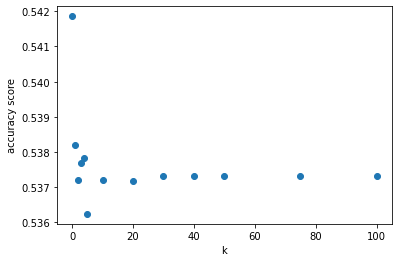

In [27]:
plt.figure()
plt.scatter(k_array,score)
plt.xlabel("k")
plt.ylabel("accuracy score")
plt.show()


## 2 Message Passing  & Isomorphisms

### 1.
**Claim:**

For two isomorphic graphs $G, H$ with edge-preserving bijection $\varphi: V(G) \rightarrow V(H)$ and initial node representations $r_0^G$ and $r_0^G$, respectively, it holds that

$$r_k^G(v) = r_k^H(\varphi(v)) \;\; \forall k\geq 0.$$

**Proof:**

Considering the claim holds for $k=0$, we only have to show that

$$r_k^G(v) = r_k^H(\varphi(v)) \Rightarrow r_{k+1}^G(v) = r_{k+1}^H(\varphi(v)) \;\; \forall k\geq 0.$$

From the isomorphism between the graphs follows that $w \in N(v) \Leftrightarrow \varphi(w) \in N(\varphi(w))$, which can be used to infer that for all $k\geq 0$

\begin{align}
&r_k^G(v) &&= r_k^H(\varphi(v))\\
\Rightarrow \;\; & \operatorname{upd}\big(r_k^G(v), \operatorname{agg}(\{\{r_k^G(w)|w \in N(v)\}\})\big) &&= \operatorname{upd}\big(r_k^H(\varphi(v)), \operatorname{agg}(\{\{r_k^H(\varphi(w))|\varphi(w) \in N(\varphi(v))\}\})\big) \\
\Leftrightarrow \;\; & r_{k+1}^G(v) &&= r_{k+1}^H(\varphi(v)).
\end{align}
Therefore, the claim is true for all $k\geq 0$.

### 2.
**Claim:**

Given two graphs $G, H$ with bijection $\varphi: V(G) \rightarrow V(H)$, if $r_k^G(v) = r_k^H(\varphi(v))$ for all $k\geq 0$ then $\varphi$ is an isomorphism.

**Disproof:**

One can construct a simple instance of the message passing framework where

$$\operatorname{upd}(\cdot, \cdot) = 0 $$

Consider two graphs $G$ with $V(G) = \{v_0, v_1\}$, $E(G) = \{\{v_0, v_1\}\}$ and $H$ with $V(H) = \{v_0', v_1'\}$, $E(G) = \{\}$. There is a bijection $\varphi$ and $r_k^G(v) = r_k^H(\varphi(v)) = 0$ for all $k \in \mathbb{N}_0$ and $v \in V(G)$, but the graphs are not isomorphic.

## 3 The Weisfeiler-Lehman Method

### 1.
**Claim:**

Let $G, H$ be two graphs with $n = |V(G)| = |V(H)|$. If the multisets of vertex representations are equal in iteration $n$, then they remain equal in all further iterations, i.e.,
$$r_n^{WL, G} = r_n^{WL, H} \Rightarrow r_{n+1}^{WL, G} = r_{n+1}^{WL, H}$$

**Proof**:

To simplify notation: $r_n \equiv r_n^{WL}$

Equal multisets if representations imply that $\forall v \in V(G): !\exists v' \in V(H): r_n(v) = r_n(v')$.

\begin{align}
r_{n+1}(v) &=  \#_n \big( r_n(v), \{\{ r_n(w) | w \in N(v) \}\} \big) \\
&\overset{(1)}{=} \#_n \big( r_n(v'), \{\{ r_n(w) | w \in N(v') \}\} \big) \\
&= r_{n+1}(v')
\end{align}

For the equality $(1)$ to hold, we must show that $r_n(v) = r_n(v') \Rightarrow \{\{ r_n(w) | w \in N(v) \}\} = \{\{ r_n(w) | w \in N(v') \}\}$


### 2.
**Claim:**

$$r_k(v) \neq r_k(u) \Rightarrow r_{k+1}(v) \neq r_{k+1}(u)$$

**Proof:**

Assume that
\begin{align}
& r_{k+1}(v) &&= r_{k+1}(u) \\
 \Leftrightarrow \;\;&\#_k \big(r_k(v), \{\{ r_k(w) | w \in N(v) \}\} \big) && = \#_k \big(r_k(u), \{\{ r_k(w) | w \in N(u) \}\} \big) \\
\Rightarrow \;\;&r_k(v) &&= r_k(u)
\end{align}

This contradicts the LHS of the claim, so the RHS must be true.

### 3.
**Claim:**

$$r_k(v) = r_k(u) \Rightarrow r_{k-1}(v) = r_{k-1}(u)$$

**Proof:**

\begin{align}
&r_k(v) &&= r_k(u) \\
\Leftrightarrow \;\; &\#_k \big(r_{k-1}(v), \{\{ r_{k-1}(w) | w \in N(v) \}\} \big) &&= \#_k \big(r_{k-1}(u), \{\{ r_{k-1}(w) | w \in N(u) \}\} \big) \\
\Rightarrow \;\; & r_{k-1}(u) &&= r_{k-1}(v)
\end{align}